# Part 2: Transform, Clean, and Analyze

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import html

sys.path.append(os.path.abspath(".."))

In [2]:
from config.settings import Config

## Data Loading

#### Yahoo Finance Stock Data

In [3]:
stock_dir = os.path.join(Config.RAW_DATA_DIR, "yahoo_finance")
stock_files = glob.glob(os.path.join(stock_dir, "stock_*.csv"))
raw_stocks_list = []

In [4]:
for file in stock_files:
    ticker = os.path.basename(file).split('_')[1]
    # Read raw yfinance output (multi-index headers, date index)
    df = pd.read_csv(file, header=[0, 1], index_col=0)
    df.index.name = 'Date'
    df.reset_index(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Ticker'] = ticker
    raw_stocks_list.append(df)

In [5]:
df_raw_stocks = pd.concat(raw_stocks_list, ignore_index=True) if raw_stocks_list else pd.DataFrame()
print(f"Loaded {len(stock_files)} Stock files into df_raw_stocks.")
df_raw_stocks.head()

Loaded 10 Stock files into df_raw_stocks.


,Date,Close,High,Low,Open,Volume,Ticker
0,2018-01-01,161.608765,162.612869,154.559726,157.019472,1171875,ATRL.KA
1,2018-01-02,163.327209,166.770853,157.727077,161.069627,2301500,ATRL.KA
2,2018-01-03,165.416290,168.374733,162.410688,163.758486,2321375,ATRL.KA
3,2018-01-04,163.832642,166.979764,163.232863,166.150868,787625,ATRL.KA
4,2018-01-05,167.646927,169.082336,162.747642,163.455237,1538250,ATRL.KA


#### PBS Macro Energy Data

In [65]:
pbs_dir = os.path.join(Config.PROCESSED_DATA_DIR, "PBS")
df_raw_cap  = pd.read_csv(os.path.join(pbs_dir, "table_4_2_installed_capacity_by_source_2006-2021.csv"))
df_raw_gen  = pd.read_csv(os.path.join(pbs_dir, "table_4_6_electricity_generation_by_source.csv"))
df_raw_gva  = pd.read_csv(os.path.join(pbs_dir, "table_4_8_gva_and_subsidy.csv"))
df_raw_prov = pd.read_csv(os.path.join(pbs_dir, "table_4_7_electricity_generation_by_province_and_source.csv"))


print("Loaded PBS files:")
print(f"  Capacity   : {df_raw_cap.shape}")
print(f"  Generation : {df_raw_gen.shape}")
print(f"  GVA/Subsidy: {df_raw_gva.shape}")
print(f"  Provincial : {df_raw_prov.shape}")
df_raw_gen.head()

Loaded PBS files:
  Capacity   : (15, 14)
  Generation : (15, 8)
  GVA/Subsidy: (15, 4)
  Provincial : (21, 8)


,Year,Nuclear,Hydel,Thermal,Bagasse,Solar,Wind,Grand Total
0,2006-07,2284,31887,65713,11,0,0,99895
1,2007-08,3077,28704,66355,15,0,0,98151
2,2008-09,1618,28180,65345,23,0,0,95166
3,2009-10,2894,28521,68918,36,0,0,100369
4,2010-11,3418,32135,66167,53,0,0,101773


In [66]:
df_raw_cap.head()

,Year,Nuclear,Nuclear % share,Hydel,Hydel % share,Thermal,Thermal % share,Bagasse,Bagasse % share,Solar,Solar % share,Wind,Wind % share,Total
0,2007,425,2.16,6474,32.91,12771,64.9,0,0.00,0,0.0,0,0.0,19670
1,2008,425,2.15,6555,33.15,12794,64.7,0,0.00,0,0.0,0,0.0,19774
2,2009,425,2.12,6555,32.74,13040,65.1,0,0.00,0,0.0,0,0.0,20020
3,2010,425,2.00,6573,30.97,14217,67.0,8,0.04,0,0.0,0,0.0,21223
4,2011,750,3.31,6573,28.99,15343,67.7,8,0.04,0,0.0,0,0.0,22674


In [67]:
df_raw_gva.head()

,Year,GVA (at current price),Subsidy,GVA Growth rate
0,2006-07,"85,896","42,617",NaN
1,2007-08,"125,756","133,254",46.4
2,2008-09,"127,515","111,640",1.4
3,2009-10,"186,540","179,526",46.3
4,2010-11,"394,396","343,144",111.4


In [68]:
df_raw_prov.head()

,Source\State,Year,Punjab,Sindh,KP,Balochistan,AJK,Total
0,Nuclear,2006-07,2099.00,186.0,0.0,0.0,0.0,2284.00
1,Nuclear,2020-21,9172.00,1918.0,0.0,0.0,0.0,11090.00
2,Nuclear,% Growth,336.83,340.0,0.0,0.0,0.0,676.83
3,Hydel,2006-07,8290.00,0.0,17405.0,0.0,6192.0,31887.00
4,Hydel,2020-21,8025.00,0.0,19316.0,0.0,11595.0,38936.00


#### Kaggle Solar Radiation Data

In [8]:
cities = ['lahore', 'karachi', 'islamabad', 'peshawar']
weather_dfs = []
for city in cities:
    file_path = os.path.join(Config.RAW_DATA_DIR, "pakistan-solar-radiation-kaggle", f"{city}_complete_data.csv")
    if os.path.exists(file_path):
        # Load only necessary columns to prevent memory overload
        df = pd.read_csv(file_path, usecols=['time', 'ghi_pyr', 'air_temperature', 'relative_humidity'])
        df['City'] = city.capitalize()
        weather_dfs.append(df)

In [9]:
len(weather_dfs)

4

In [10]:
weather_dfs[0].head()

,time,ghi_pyr,air_temperature,relative_humidity,City
0,2014-10-22 12:20:00,666.8,30.3,42.5,Lahore
1,2014-10-22 12:30:00,658.8,30.4,42.2,Lahore
2,2014-10-22 12:40:00,646.5,30.7,41.8,Lahore
3,2014-10-22 12:50:00,641.5,30.8,41.8,Lahore
4,2014-10-22 13:00:00,640.0,31.3,40.5,Lahore


In [11]:
weather_dfs[1].head()

,time,ghi_pyr,air_temperature,relative_humidity,City
0,2015-04-22 14:40:00,846.6,36.4,17.1,Karachi
1,2015-04-22 14:50:00,810.1,34.9,30.8,Karachi
2,2015-04-22 15:00:00,808.0,34.5,28.6,Karachi
3,2015-04-22 15:10:00,784.0,34.7,27.2,Karachi
4,2015-04-22 15:20:00,745.2,35.0,27.7,Karachi


In [12]:
weather_dfs[2].head()

,time,ghi_pyr,air_temperature,relative_humidity,City
0,2014-10-25 13:10:00,628.3,25.5,46.9,Islamabad
1,2014-10-25 13:20:00,618.6,25.3,47.2,Islamabad
2,2014-10-25 13:30:00,603.9,25.4,46.4,Islamabad
3,2014-10-25 13:40:00,584.1,25.5,46.2,Islamabad
4,2014-10-25 13:50:00,564.7,25.4,47.1,Islamabad


In [13]:
weather_dfs[3].head()

,time,ghi_pyr,air_temperature,relative_humidity,City
0,2015-04-10 16:10:00,155.0,29.0,38.6,Peshawar
1,2015-04-10 16:20:00,139.4,28.9,39.4,Peshawar
2,2015-04-10 16:30:00,123.8,28.7,39.8,Peshawar
3,2015-04-10 16:40:00,109.4,28.7,39.4,Peshawar
4,2015-04-10 16:50:00,94.5,28.6,38.9,Peshawar


In [14]:
df_raw_weather = pd.concat(weather_dfs, ignore_index=True) if weather_dfs else pd.DataFrame()
print(f"Loaded {len(weather_dfs)} City Solar Radiation files into df_raw_weather.")

df_raw_weather.head()

Loaded 4 City Solar Radiation files into df_raw_weather.


,time,ghi_pyr,air_temperature,relative_humidity,City
0,2014-10-22 12:20:00,666.8,30.3,42.5,Lahore
1,2014-10-22 12:30:00,658.8,30.4,42.2,Lahore
2,2014-10-22 12:40:00,646.5,30.7,41.8,Lahore
3,2014-10-22 12:50:00,641.5,30.8,41.8,Lahore
4,2014-10-22 13:00:00,640.0,31.3,40.5,Lahore


#### Solar Generation Data

In [15]:
gen_path = os.path.join(Config.RAW_DATA_DIR, "pakistan-electricity-generation-by-solar-kaggle", "data_series.csv")
df_raw_solar_gen = pd.read_csv(gen_path) if os.path.exists(gen_path) else pd.DataFrame()
print("Loaded Solar Generation Data.")
df_raw_solar_gen.head()

Loaded Solar Generation Data.


,Series,Observation Date,Observation Value,Unit
0,Elec GEN by Solar,30-Sep-23,78.793,GWh
1,Elec GEN by Solar,31-Aug-23,84.071,GWh
2,Elec GEN by Solar,31-Jul-23,75.190,GWh
3,Elec GEN by Solar,30-Jun-23,105.060,GWh
4,Elec GEN by Solar,31-May-23,124.060,GWh


#### Youtube Comments Data

In [16]:
yt_file = os.path.join(Config.RAW_DATA_DIR, "yt_comments", "matched_comments.json")
parsed_comments = []

In [17]:
if os.path.exists(yt_file):
    with open(yt_file, 'r', encoding='utf-8') as f:
        raw_yt = json.load(f)
    for video_id, video_info in raw_yt.items():
        title = video_info.get("video_title", "")
        for item in video_info.get("raw_threads", []):
            top_comment = item["snippet"]["topLevelComment"]["snippet"]
            parsed_comments.append({
                "Video_Title": title,
                "Comment_ID": item["snippet"]["topLevelComment"]["id"],
                "Published_At": top_comment.get("publishedAt"),
                "Like_Count": top_comment.get("likeCount", 0),
                "Comment": top_comment.get("textDisplay")
            })
            for reply in item.get("fetched_replies", []):
                r_snippet = reply["snippet"]
                parsed_comments.append({
                    "Video_Title": title,
                    "Comment_ID": reply["id"],
                    "Published_At": r_snippet.get("publishedAt"),
                    "Like_Count": r_snippet.get("likeCount", 0),
                    "Comment": r_snippet.get("textDisplay")
                })
df_raw_yt = pd.DataFrame(parsed_comments)
print("Loaded and flattened YouTube JSON into df_raw_yt.")
df_raw_yt.head()

Loaded and flattened YouTube JSON into df_raw_yt.


,Video_Title,Comment_ID,Published_At,Like_Count,Comment
0,Pakistan Ends Net-Metering: What the New Solar...,UgyaVOHzmGsForN7Ma14AaABAg,2026-02-11T17:38:36Z,7,😂😂\nWe boycott National Grid. Why become slave...
1,Pakistan Ends Net-Metering: What the New Solar...,UgyVA9Wc3cCnwX3BiUV4AaABAg,2026-02-13T18:58:38Z,3,"1:46, If fragile power system is fragile & cos..."
2,Pakistan Ends Net-Metering: What the New Solar...,UgyXd_ESBvq3h9XVsKF4AaABAg,2026-02-13T09:36:03Z,0,A policy favour for the elites by the elites i...
3,Pakistan Ends Net-Metering: What the New Solar...,Ugwphwyu5Eppw3oR5Q14AaABAg,2026-02-11T15:59:49Z,0,Solar is still worth it through hybrid means h...
4,Pakistan Ends Net-Metering: What the New Solar...,UgzjrNexwVABPmoYqGN4AaABAg,2026-02-13T15:18:21Z,0,Ff


## Raw Data Analysis

In [18]:
def analyze_raw_dataframe(name, df):
    print(f"\n--- {name.upper()} ---")
    if df.empty:
        print("Dataframe is empty.")
        return
    
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # 1. Duplicates
    dup_count = df.duplicated().sum()
    print(f"Exact Duplicate Rows: {dup_count} ({(dup_count/len(df))*100:.2f}%)")
    
    # 2. Missing Values (Focus on problematic columns)
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0]
    if not nulls.empty:
        print("Missing Values per Column:")
        for col, count in nulls.items():
            print(f"   - {col}: {count} nulls ({(count/len(df))*100:.2f}%)")
    else:
        print("Missing Values: None")
        
    # 3. Quick Numerical Describe
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\nNumerical Statistics Overview:")
        print(df[num_cols].describe().loc[['mean', 'min', 'max', 'std']].round(2).to_string())

In [19]:
analyze_raw_dataframe("Raw Stock Data", df_raw_stocks)


--- RAW STOCK DATA ---
Shape: 20741 rows, 7 columns
Exact Duplicate Rows: 0 (0.00%)
Missing Values: None

Numerical Statistics Overview:
        Close     High      Low     Open        Volume
mean   220.65   223.74   217.94   220.89  3.126724e+06
min      8.24     8.34     8.10     8.10  0.000000e+00
max   3351.62  3359.05  3249.99  3249.99  1.323551e+08
std    388.58   393.33   384.12   388.74  5.588682e+06


In [20]:
analyze_raw_dataframe("Raw PBS Generation", df_raw_gen)


--- RAW PBS GENERATION ---
Shape: 15 rows, 8 columns
Exact Duplicate Rows: 0 (0.00%)
Missing Values: None

Numerical Statistics Overview:
       Nuclear     Hydel   Thermal  Bagasse   Solar     Wind  Grand Total
mean   5696.20  31882.40  74199.20   372.07  274.40   939.73    113364.00
min    1618.00  27729.00  65297.00    11.00    0.00     0.00     95166.00
max   11090.00  38936.00  93948.00  1020.00  911.00  3232.00    143847.00
std    3028.79   3467.48  10163.22   402.93  379.19  1236.51     16727.25


In [21]:
analyze_raw_dataframe("Raw Solar Radiation (Weather)", df_raw_weather)


--- RAW SOLAR RADIATION (WEATHER) ---
Shape: 479618 rows, 5 columns


Exact Duplicate Rows: 0 (0.00%)
Missing Values per Column:
   - ghi_pyr: 3357 nulls (0.70%)
   - air_temperature: 3358 nulls (0.70%)
   - relative_humidity: 3358 nulls (0.70%)

Numerical Statistics Overview:
      ghi_pyr  air_temperature  relative_humidity
mean   194.54            23.47              62.13
min      0.00             0.80               3.00
max   1140.00            46.10             100.00
std    278.38             8.17              21.77


In [22]:
analyze_raw_dataframe("Raw Solar Generation", df_raw_solar_gen)


--- RAW SOLAR GENERATION ---
Shape: 99 rows, 4 columns
Exact Duplicate Rows: 0 (0.00%)
Missing Values: None

Numerical Statistics Overview:
      Observation Value
mean              57.02
min                9.00
max              125.80
std               23.46


In [23]:
analyze_raw_dataframe("Raw YouTube Discourse", df_raw_yt)


--- RAW YOUTUBE DISCOURSE ---
Shape: 2783 rows, 5 columns
Exact Duplicate Rows: 0 (0.00%)
Missing Values: None

Numerical Statistics Overview:
      Like_Count
mean        0.93
min         0.00
max        76.00
std         3.09


### CROSS-TABLE TEMPORAL ANALYSIS

In [24]:
print("Analyzing the time boundaries to identify analytical overlap zones...\n")

try:
    stock_start = pd.to_datetime(df_raw_stocks['Date'], utc=True).min().strftime('%Y-%m')
    stock_end = pd.to_datetime(df_raw_stocks['Date'], utc=True).max().strftime('%Y-%m')
    
    pbs_start = df_raw_gen['Year'].iloc[0]
    pbs_end = df_raw_gen['Year'].iloc[-1]
    
    sol_gen_start = pd.to_datetime(df_raw_solar_gen['Observation Date']).min().strftime('%Y-%m')
    sol_gen_end = pd.to_datetime(df_raw_solar_gen['Observation Date']).max().strftime('%Y-%m')
    
    yt_start = pd.to_datetime(df_raw_yt['Published_At']).min().strftime('%Y-%m')
    yt_end = pd.to_datetime(df_raw_yt['Published_At']).max().strftime('%Y-%m')

    print(f"Stocks:             {stock_start}  to  {stock_end}")
    print(f"PBS Macro Data:     {pbs_start}  to  {pbs_end}")
    print(f"Kaggle Solar Gen:   {sol_gen_start}  to  {sol_gen_end}")
    print(f"YouTube Sentiment:  {yt_start}  to  {yt_end}")
    
    print("\n[Cross-Table Insight]:")
    print("The most robust overlap for all 4 distinct datasets occurs roughly between 2018 and 2021.")
    print("Stock and YouTube data are highly granular (daily/real-time), while PBS is annual. Merging will require resampling.")
except Exception as e:
    print(f"Could not complete temporal cross-analysis: {e}")

Analyzing the time boundaries to identify analytical overlap zones...

Stocks:             2018-01  to  2026-02
PBS Macro Data:     2006-07  to  2020-21
Kaggle Solar Gen:   2015-07  to  2023-09
YouTube Sentiment:  2024-05  to  2026-02

[Cross-Table Insight]:
The most robust overlap for all 4 distinct datasets occurs roughly between 2018 and 2021.
Stock and YouTube data are highly granular (daily/real-time), while PBS is annual. Merging will require resampling.


C:\Users\Talib\AppData\Local\Temp\ipykernel_21644\4141143608.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sol_gen_start = pd.to_datetime(df_raw_solar_gen['Observation Date']).min().strftime('%Y-%m')
C:\Users\Talib\AppData\Local\Temp\ipykernel_21644\4141143608.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sol_gen_end = pd.to_datetime(df_raw_solar_gen['Observation Date']).max().strftime('%Y-%m')


#### Stock Ticker Breakdown & Coverage
Understanding what each of the 10 tickers represents before selecting a visualization subset.

In [25]:
TICKER_INFO = {
    'HUBC.KA':    ('Hub Power Company',        'Traditional IPP (Thermal)'),
    'KAPCO.KA':   ('Kot Addu Power Company',   'Traditional IPP (Thermal)'),
    'NCPL.KA':    ('Nishat Chunian Power',      'Traditional IPP (Thermal)'),
    'NPEL.KA':    ('Nishat Power',              'Traditional IPP (Thermal)'),
    'ENGRO.KA':   ('Engro Corporation',         'Diversified Energy'),
    'PSO.KA':     ('Pakistan State Oil',        'Fossil Fuel / Oil'),
    'ATRL.KA':    ('Attock Refinery',           'Fossil Fuel / Refinery'),
    'PAEL.KA':    ('Pak Elektron Ltd',          'Solar Appliances / Electronics'),
    'LOTCHEM.KA': ('Lotte Chemical Pakistan',   'Petrochemical'),
    'KEL.KA':     ('K-Electric',               'Grid Utility / Distribution'),
}
print(f"{'Ticker':<14} {'Company':<36} {'Sector'}")
print("-"*75)
for t,(c,s) in TICKER_INFO.items():
    print(f"{t:<14} {c:<36} {s}")
print()
print("Subset for main visualization:")
print("  HUBC.KA  - Largest thermal IPP:          proxy for traditional grid health")
print("  PAEL.KA  - Solar appliance maker:         direct solar adoption beneficiary")
print("  ENGRO.KA - Diversified energy major:      broader energy economy indicator")
print("  PSO.KA   - State oil:                     fossil fuel baseline reference")

Ticker         Company                              Sector
---------------------------------------------------------------------------
HUBC.KA        Hub Power Company                    Traditional IPP (Thermal)
KAPCO.KA       Kot Addu Power Company               Traditional IPP (Thermal)
NCPL.KA        Nishat Chunian Power                 Traditional IPP (Thermal)
NPEL.KA        Nishat Power                         Traditional IPP (Thermal)
ENGRO.KA       Engro Corporation                    Diversified Energy
PSO.KA         Pakistan State Oil                   Fossil Fuel / Oil
ATRL.KA        Attock Refinery                      Fossil Fuel / Refinery
PAEL.KA        Pak Elektron Ltd                     Solar Appliances / Electronics
LOTCHEM.KA     Lotte Chemical Pakistan              Petrochemical
KEL.KA         K-Electric                           Grid Utility / Distribution

Subset for main visualization:
  HUBC.KA  - Largest thermal IPP:          proxy for traditional grid health

In [26]:
coverage = (
    df_raw_stocks.groupby('Ticker')
    .agg(Start=('Date','min'), End=('Date','max'), Trading_Days=('Date','count'))
    .reset_index()
)
coverage['Years'] = (pd.to_datetime(coverage['End']) - pd.to_datetime(coverage['Start'])).dt.days / 365.25
print("-- Per-Ticker Data Coverage --")
print(coverage.to_string(index=False))

-- Per-Ticker Data Coverage --
  Ticker      Start        End  Trading_Days    Years
 ATRL.KA 2018-01-01 2026-02-17          2102 8.128679
ENGRO.KA 2018-01-01 2025-01-13          1823 7.033539
 HUBC.KA 2018-01-01 2026-02-17          2102 8.128679
 MARI.KA 2018-01-01 2026-02-17          2102 8.128679
 OGDC.KA 2018-01-01 2026-02-17          2102 8.128679
 PAEL.KA 2018-01-01 2026-02-17          2102 8.128679
  PPL.KA 2018-01-01 2026-02-17          2102 8.128679
  PSO.KA 2018-01-01 2026-02-17          2102 8.128679
 SNGP.KA 2018-01-01 2026-02-17          2102 8.128679
 SSGC.KA 2018-01-01 2026-02-17          2102 8.128679


#### Comment Length Histogram (Raw YouTube)
Visualizing comment length distribution before the noise filter. 
Justifies the threshold choice.

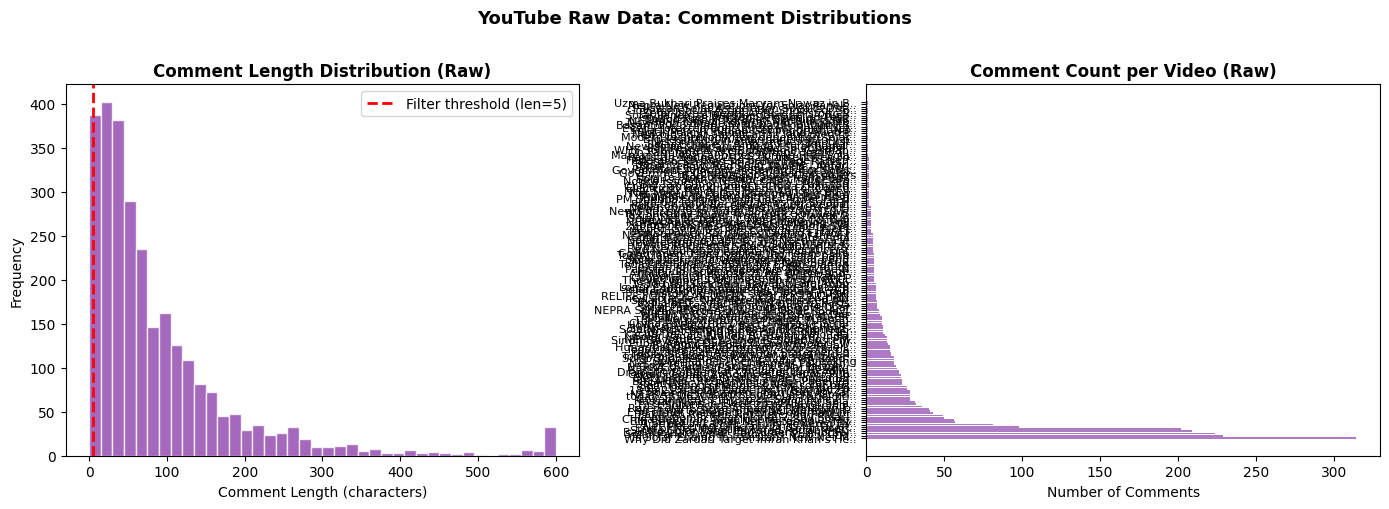

Comments with length <= 5 (noise): 152 (5.5%)


In [27]:
df_raw_yt['Comment_Length_raw'] = df_raw_yt['Comment'].astype(str).apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of comment lengths
axes[0].hist(df_raw_yt['Comment_Length_raw'].clip(upper=600), bins=40,
             color='#8e44ad', edgecolor='white', alpha=0.8)
axes[0].axvline(5, color='red', linestyle='--', linewidth=2, label='Filter threshold (len=5)')
axes[0].set_title('Comment Length Distribution (Raw)', fontweight='bold')
axes[0].set_xlabel('Comment Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Bar chart: comment count per video
video_counts = df_raw_yt['Video_Title'].apply(lambda x: x[:40]).value_counts()
axes[1].barh(range(len(video_counts)), video_counts.values, color='#9b59b6', alpha=0.8)
axes[1].set_yticks(range(len(video_counts)))
axes[1].set_yticklabels([v[:38]+'..' if len(v)>38 else v for v in video_counts.index], fontsize=8)
axes[1].set_title('Comment Count per Video (Raw)', fontweight='bold')
axes[1].set_xlabel('Number of Comments')

plt.suptitle('YouTube Raw Data: Comment Distributions', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

noise = (df_raw_yt['Comment_Length_raw'] <= 5).sum()
print(f"Comments with length <= 5 (noise): {noise} ({noise/len(df_raw_yt)*100:.1f}%)")

## Data Cleaning & Transformation

#### Cleaning Stocks: Standardizing dates and forward-filling (ffill) missing trading days.

In [28]:
df_clean_stocks = df_raw_stocks.copy()
df_clean_stocks['Date'] = pd.to_datetime(df_clean_stocks['Date'], utc=True).dt.tz_convert(None)

# FIX: ffill price/volume per-ticker only (not across ticker boundaries)
price_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
df_clean_stocks[price_cols] = (
    df_clean_stocks.groupby('Ticker')[price_cols].ffill()
)
df_clean_stocks.dropna(subset=price_cols, inplace=True)
df_clean_stocks.drop_duplicates(inplace=True)
df_clean_stocks.to_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_stocks.csv"), index=False)

print("Stocks cleaned.")
print(f"  Shape: {df_clean_stocks.shape}")
print(f"  Date range: {df_clean_stocks['Date'].min().date()} to {df_clean_stocks['Date'].max().date()}")
print(f"  Tickers ({df_clean_stocks['Ticker'].nunique()}): {sorted(df_clean_stocks['Ticker'].unique())}")
print()
print("-- Cleaned Stocks Summary Statistics --")
print(df_clean_stocks[price_cols].describe().round(2))
assert df_clean_stocks['Close'].isna().sum() == 0, "NaNs in Close!"
assert df_clean_stocks.duplicated().sum() == 0, "Duplicates found!"
print("\nAssertions passed: No NaNs, No Duplicates.")

Stocks cleaned.
  Shape: (20741, 7)
  Date range: 2018-01-01 to 2026-02-17
  Tickers (10): ['ATRL.KA', 'ENGRO.KA', 'HUBC.KA', 'MARI.KA', 'OGDC.KA', 'PAEL.KA', 'PPL.KA', 'PSO.KA', 'SNGP.KA', 'SSGC.KA']

-- Cleaned Stocks Summary Statistics --
          Close      High       Low      Open        Volume
count  20741.00  20741.00  20741.00  20741.00  2.074100e+04
mean     220.65    223.74    217.94    220.89  3.126724e+06
std      388.58    393.33    384.12    388.74  5.588682e+06
min        8.24      8.34      8.10      8.10  0.000000e+00
25%       33.28     33.74     32.85     33.30  4.556420e+05
50%       89.04     90.25     87.95     89.19  1.326944e+06
75%      166.39    168.44    164.55    166.60  3.459932e+06
max     3351.62   3359.05   3249.99   3249.99  1.323551e+08

Assertions passed: No NaNs, No Duplicates.


#### Cleaning PBS: Standardizing 'Fiscal_Year' string arrays and calculating 'Grid Utilization Pct'.

In [69]:
df_gen_clean  = df_raw_gen.copy()
df_cap_clean  = df_raw_cap.copy()
df_gva_clean  = df_raw_gva.copy()
df_prov_clean = df_raw_prov.copy()

In [70]:
# Fiscal Year standardization
df_gen_clean['Fiscal_Year']  = df_gen_clean['Year'].apply(lambda x: int(str(x).split('-')[0]) + 1)
df_cap_clean['Fiscal_Year']  = df_cap_clean['Year'].astype(int)
df_gva_clean['Fiscal_Year']  = df_gva_clean['Year'].apply(
    lambda x: int(str(x).split('-')[0]) + 1 if pd.notna(x) else None)
df_prov_clean['Fiscal_Year'] = df_prov_clean['Year'].apply(
    lambda x: int(str(x).split('-')[0]) + 1 if pd.notna(x) and '-' in str(x) else None)

# Generation: clean commas, keep all source columns
for col in ['Nuclear', 'Hydel', 'Thermal', 'Bagasse', 'Solar', 'Wind', 'Grand Total']:
    if col in df_gen_clean.columns:
        df_gen_clean[col] = df_gen_clean[col].astype(str).str.replace(',', '').astype(float)

df_gen_clean = df_gen_clean[
    ['Fiscal_Year', 'Nuclear', 'Hydel', 'Thermal', 'Bagasse', 'Solar', 'Wind', 'Grand Total']
].rename(columns={
    'Solar': 'Solar_Gen_GWh',   'Grand Total': 'Total_Gen_GWh',
    'Nuclear': 'Nuclear_Gen_GWh', 'Hydel': 'Hydel_Gen_GWh',
    'Thermal': 'Thermal_Gen_GWh', 'Bagasse': 'Bagasse_Gen_GWh', 'Wind': 'Wind_Gen_GWh'
})

# -- Capacity -----------------------------------------------------------------
df_cap_clean = df_cap_clean[['Fiscal_Year', 'Solar', 'Total']].rename(
    columns={'Solar': 'Solar_Cap_MW', 'Total': 'Total_Cap_MW'})

# -- GVA & Subsidy ------------------------------------------------------------
for col in ['GVA (at current price)', 'Subsidy']:
    if col in df_gva_clean.columns:
        df_gva_clean[col] = df_gva_clean[col].astype(str).str.replace(',', '').astype(float)

df_gva_clean = df_gva_clean[['Fiscal_Year', 'GVA (at current price)', 'Subsidy']].rename(columns={
    'GVA (at current price)': 'GVA_Investment_Millions',
    'Subsidy':                'Subsidy_Millions'
})

# -- Provincial generation ----------------------------------------------------
df_prov_overall = (
    df_prov_clean[df_prov_clean['Source\\State'] == 'Overall']
    [['Fiscal_Year', 'Punjab', 'Sindh', 'KP', 'Balochistan']]
    .rename(columns={c: f"{c}_Total_Gen_GWh" for c in ['Punjab', 'Sindh', 'KP', 'Balochistan']})
)

df_prov_solar = (
    df_prov_clean[df_prov_clean['Source\\State'] == 'Solar']
    [['Fiscal_Year', 'Punjab', 'Sindh']]
    .rename(columns={'Punjab': 'Punjab_Solar_Gen_GWh', 'Sindh': 'Sindh_Solar_Gen_GWh'})
)

# # Clean numeric strings with commas
# gen_source_cols = ['Nuclear', 'Hydel', 'Thermal', 'Bagasse', 'Solar', 'Wind', 'Grand Total']
# for col in gen_source_cols:
#     if col in df_gen_clean.columns:
#         df_gen_clean[col] = df_gen_clean[col].astype(str).str.replace(',', '').astype(float)

# df_gen_clean = df_gen_clean[
#     ['Fiscal_Year','Nuclear','Hydel','Thermal','Bagasse','Solar','Wind','Grand Total']
# ].rename(columns={
#     'Solar':'Solar_Gen_GWh', 'Grand Total':'Total_Gen_GWh',
#     'Nuclear':'Nuclear_Gen_GWh', 'Hydel':'Hydel_Gen_GWh',
#     'Thermal':'Thermal_Gen_GWh', 'Bagasse':'Bagasse_Gen_GWh', 'Wind':'Wind_Gen_GWh'
# })

# df_cap_clean = df_cap_clean[['Fiscal_Year', 'Solar', 'Total']].rename(columns={'Solar': 'Solar_Cap_MW', 'Total': 'Total_Cap_MW'})

In [71]:
df_pbs = df_gen_clean.merge(df_cap_clean, on='Fiscal_Year', how='left')
df_pbs = df_pbs.merge(df_gva_clean, on='Fiscal_Year', how='left')
df_pbs = df_pbs.merge(df_prov_overall, on='Fiscal_Year', how='left')
df_pbs = df_pbs.merge(df_prov_solar, on='Fiscal_Year', how='left')

In [72]:
df_pbs['Solar_Gen_Share_Pct']   = (df_pbs['Solar_Gen_GWh'] / df_pbs['Total_Gen_GWh']) * 100
df_pbs['Total_Utilization_Pct'] = (df_pbs['Total_Gen_GWh'] * 1000) / (df_pbs['Total_Cap_MW'] * 8760) * 100
df_pbs['Solar_Utilization_Pct'] = 0.0
mask = df_pbs['Solar_Cap_MW'] > 0
df_pbs.loc[mask, 'Solar_Utilization_Pct'] = (
    df_pbs.loc[mask, 'Solar_Gen_GWh'] * 1000) / (df_pbs.loc[mask, 'Solar_Cap_MW'] * 8760) * 100

df_pbs.to_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_pbs.csv"), index=False)

print("PBS cleaned and merged.")
print(f"  Shape: {df_pbs.shape}")
print(f"  Columns: {list(df_pbs.columns)}")
print()
print("-- Summary Statistics --")
num_cols = ['Solar_Gen_GWh', 'Total_Gen_GWh', 'Total_Cap_MW',
            'Total_Utilization_Pct', 'GVA_Investment_Millions', 'Subsidy_Millions']
print(df_pbs[num_cols].describe().round(2))

assert df_pbs['Total_Gen_GWh'].isna().sum() == 0
print("\nAssertions passed: No NaNs in generation totals.")

PBS cleaned and merged.
  Shape: (15, 21)
  Columns: ['Fiscal_Year', 'Nuclear_Gen_GWh', 'Hydel_Gen_GWh', 'Thermal_Gen_GWh', 'Bagasse_Gen_GWh', 'Solar_Gen_GWh', 'Wind_Gen_GWh', 'Total_Gen_GWh', 'Solar_Cap_MW', 'Total_Cap_MW', 'GVA_Investment_Millions', 'Subsidy_Millions', 'Punjab_Total_Gen_GWh', 'Sindh_Total_Gen_GWh', 'KP_Total_Gen_GWh', 'Balochistan_Total_Gen_GWh', 'Punjab_Solar_Gen_GWh', 'Sindh_Solar_Gen_GWh', 'Solar_Gen_Share_Pct', 'Total_Utilization_Pct', 'Solar_Utilization_Pct']

-- Summary Statistics --
       Solar_Gen_GWh  Total_Gen_GWh  Total_Cap_MW  Total_Utilization_Pct  \
count          15.00          15.00         15.00                  15.00   
mean          274.40      113364.00      27451.20                  48.62   
std           379.19       16727.25       7598.79                   6.00   
min             0.00       95166.00      19670.00                  38.17   
25%             0.00      100132.00      21948.50                  44.29   
50%             0.00      1077

In [73]:
df_pbs.head()

,Fiscal_Year,Nuclear_Gen_GWh,Hydel_Gen_GWh,Thermal_Gen_GWh,Bagasse_Gen_GWh,Solar_Gen_GWh,Wind_Gen_GWh,Total_Gen_GWh,Solar_Cap_MW,Total_Cap_MW,...,Subsidy_Millions,Punjab_Total_Gen_GWh,Sindh_Total_Gen_GWh,KP_Total_Gen_GWh,Balochistan_Total_Gen_GWh,Punjab_Solar_Gen_GWh,Sindh_Solar_Gen_GWh,Solar_Gen_Share_Pct,Total_Utilization_Pct,Solar_Utilization_Pct
0,2007,2284.0,31887.0,65713.0,11.0,0.0,0.0,99895.0,0,19670,...,42617.0,37470.0,26089.0,17498.0,12646.0,0.0,0.0,0.0,57.974270,0.0
1,2008,3077.0,28704.0,66355.0,15.0,0.0,0.0,98151.0,0,19774,...,133254.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,56.662547,0.0
2,2009,1618.0,28180.0,65345.0,23.0,0.0,0.0,95166.0,0,20020,...,111640.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.264229,0.0
3,2010,2894.0,28521.0,68918.0,36.0,0.0,0.0,100369.0,0,21223,...,179526.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,53.986941,0.0
4,2011,3418.0,32135.0,66167.0,53.0,0.0,0.0,101773.0,0,22674,...,343144.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,51.238963,0.0


#### Cleaning Radiation: Dropping physically impossible anomalies (GHI < 0) and mathematically aggregating to hourly means.

In [52]:
df_weather_clean = df_raw_weather.copy()

# Remove physically impossible readings AND rows with any NaN sensor value
df_weather_clean = df_weather_clean[df_weather_clean['ghi_pyr'] >= 0].dropna()

df_weather_clean['time'] = pd.to_datetime(df_weather_clean['time'])
df_weather_clean['Hour'] = df_weather_clean['time'].dt.hour
df_weather_clean['Month'] = df_weather_clean['time'].dt.month

print("Weather cleaned.")
print(f"  Rows after cleaning: {len(df_weather_clean):,}  (removed {len(df_raw_weather)-len(df_weather_clean):,})")
print(f"  Remaining NaNs: {df_weather_clean.isnull().sum().sum()}")
print()
print("-- Date Coverage Per City --")
for city, grp in df_weather_clean.groupby('City'):
    t = grp['time']
    print(f"  {city:12s}: {t.min().date()} to {t.max().date()}  ({len(grp):,} readings)")

Weather cleaned.
  Rows after cleaning: 476,260  (removed 3,358)
  Remaining NaNs: 0

-- Date Coverage Per City --
  Islamabad   : 2014-10-25 to 2017-05-01  (131,762 readings)
  Karachi     : 2015-04-22 to 2017-05-01  (106,473 readings)
  Lahore      : 2014-10-22 to 2017-05-01  (129,833 readings)
  Peshawar    : 2015-04-10 to 2017-05-01  (108,192 readings)


In [53]:
# Aggregate 10-min ping data into hourly means per City/Month/Hour.
# Daily Insolation formula: Insolation (kWh/m2/day) = sum(GHI_hour * dt) / 1000
# where dt = 1 hour. Summing hourly-mean GHI across all hours gives a daily
# insolation proxy; dividing by 1000 converts W/m2 to kWh/m2.
df_weather_agg = (
    df_weather_clean
    .groupby(['City','Month','Hour'])[['ghi_pyr','air_temperature','relative_humidity']]
    .mean()
    .reset_index()
)
df_weather_agg.rename(
    columns={'ghi_pyr':'GHI','air_temperature':'Temperature','relative_humidity':'Humidity'},
    inplace=True)
df_weather_agg.to_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_solar_radiation_by_city.csv"), index=False)

print("Weather aggregated.")
print(f"  Shape: {df_weather_agg.shape}")
print()
print("-- Cleaned Weather Summary Statistics --")
print(df_weather_agg[['GHI','Temperature','Humidity']].describe().round(2))
assert df_weather_agg['GHI'].min() >= 0, "Negative GHI values found!"
print("\nAssertions passed: No negative GHI values.")

Weather aggregated.
  Shape: (1152, 6)

-- Cleaned Weather Summary Statistics --
           GHI  Temperature  Humidity
count  1152.00      1152.00   1152.00
mean    198.28        24.16     61.82
std     264.51         7.49     16.72
min       0.00         6.56     22.97
25%       0.00        18.48     49.74
50%       9.60        25.90     61.99
75%     399.45        29.82     74.70
max     941.30        39.72     96.25

Assertions passed: No negative GHI values.


#### Cleaning Solar Generation: Converting text dates and coercing numeric data.

In [33]:
df_sol_gen_clean = df_raw_solar_gen.copy()
df_sol_gen_clean['Date'] = pd.to_datetime(df_sol_gen_clean['Observation Date'])
df_sol_gen_clean['Solar_Gen_GWh'] = pd.to_numeric(df_sol_gen_clean['Observation Value'], errors='coerce')
df_sol_gen_clean = df_sol_gen_clean[['Date', 'Solar_Gen_GWh']].dropna().sort_values('Date').reset_index(drop=True)
df_sol_gen_clean.to_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_solar_generation.csv"), index=False)

C:\Users\Talib\AppData\Local\Temp\ipykernel_21644\4146975928.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sol_gen_clean['Date'] = pd.to_datetime(df_sol_gen_clean['Observation Date'])


#### Cleaning YouTube: Deduplicating paginated overlaps and filtering noise (length < 5).

In [34]:
df_yt_clean = df_raw_yt.copy()

# Deduplicate paginated API overlaps
df_yt_clean.drop_duplicates(subset=['Comment_ID'], inplace=True)

# FIX: Strip HTML entities (e.g. &amp; &#39;) and encoding artefacts
df_yt_clean['Comment'] = df_yt_clean['Comment'].astype(str).apply(html.unescape)

df_yt_clean['Published_At'] = pd.to_datetime(df_yt_clean['Published_At'])
df_yt_clean['Comment_Length'] = df_yt_clean['Comment'].apply(len)

n_before = len(df_yt_clean)
df_yt_clean = df_yt_clean[df_yt_clean['Comment_Length'] > 5]
print("YouTube cleaned.")
print(f"  Removed {n_before - len(df_yt_clean)} noise comments (length <= 5)")
print(f"  Remaining: {len(df_yt_clean):,} comments  |  Unique videos: {df_yt_clean['Video_Title'].nunique()}")
print()
print("-- Cleaned YouTube Summary Statistics --")
print(df_yt_clean[['Like_Count','Comment_Length']].describe().round(2))
df_yt_clean.to_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_youtube.csv"), index=False)
assert df_yt_clean['Comment_ID'].nunique() == len(df_yt_clean), "Duplicate Comment IDs remain!"
print("\nAssertions passed: All Comment IDs are unique.")

YouTube cleaned.
  Removed 152 noise comments (length <= 5)
  Remaining: 2,631 comments  |  Unique videos: 146

-- Cleaned YouTube Summary Statistics --
       Like_Count  Comment_Length
count     2631.00         2631.00
mean         0.96           96.58
std          3.17          115.41
min          0.00            6.00
25%          0.00           30.00
50%          0.00           60.00
75%          1.00          119.00
max         76.00         1153.00

Assertions passed: All Comment IDs are unique.


## Data Exploratory Analysis and Visualization

#### PBS macro data

In [74]:
pbs_df = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_pbs.csv"))

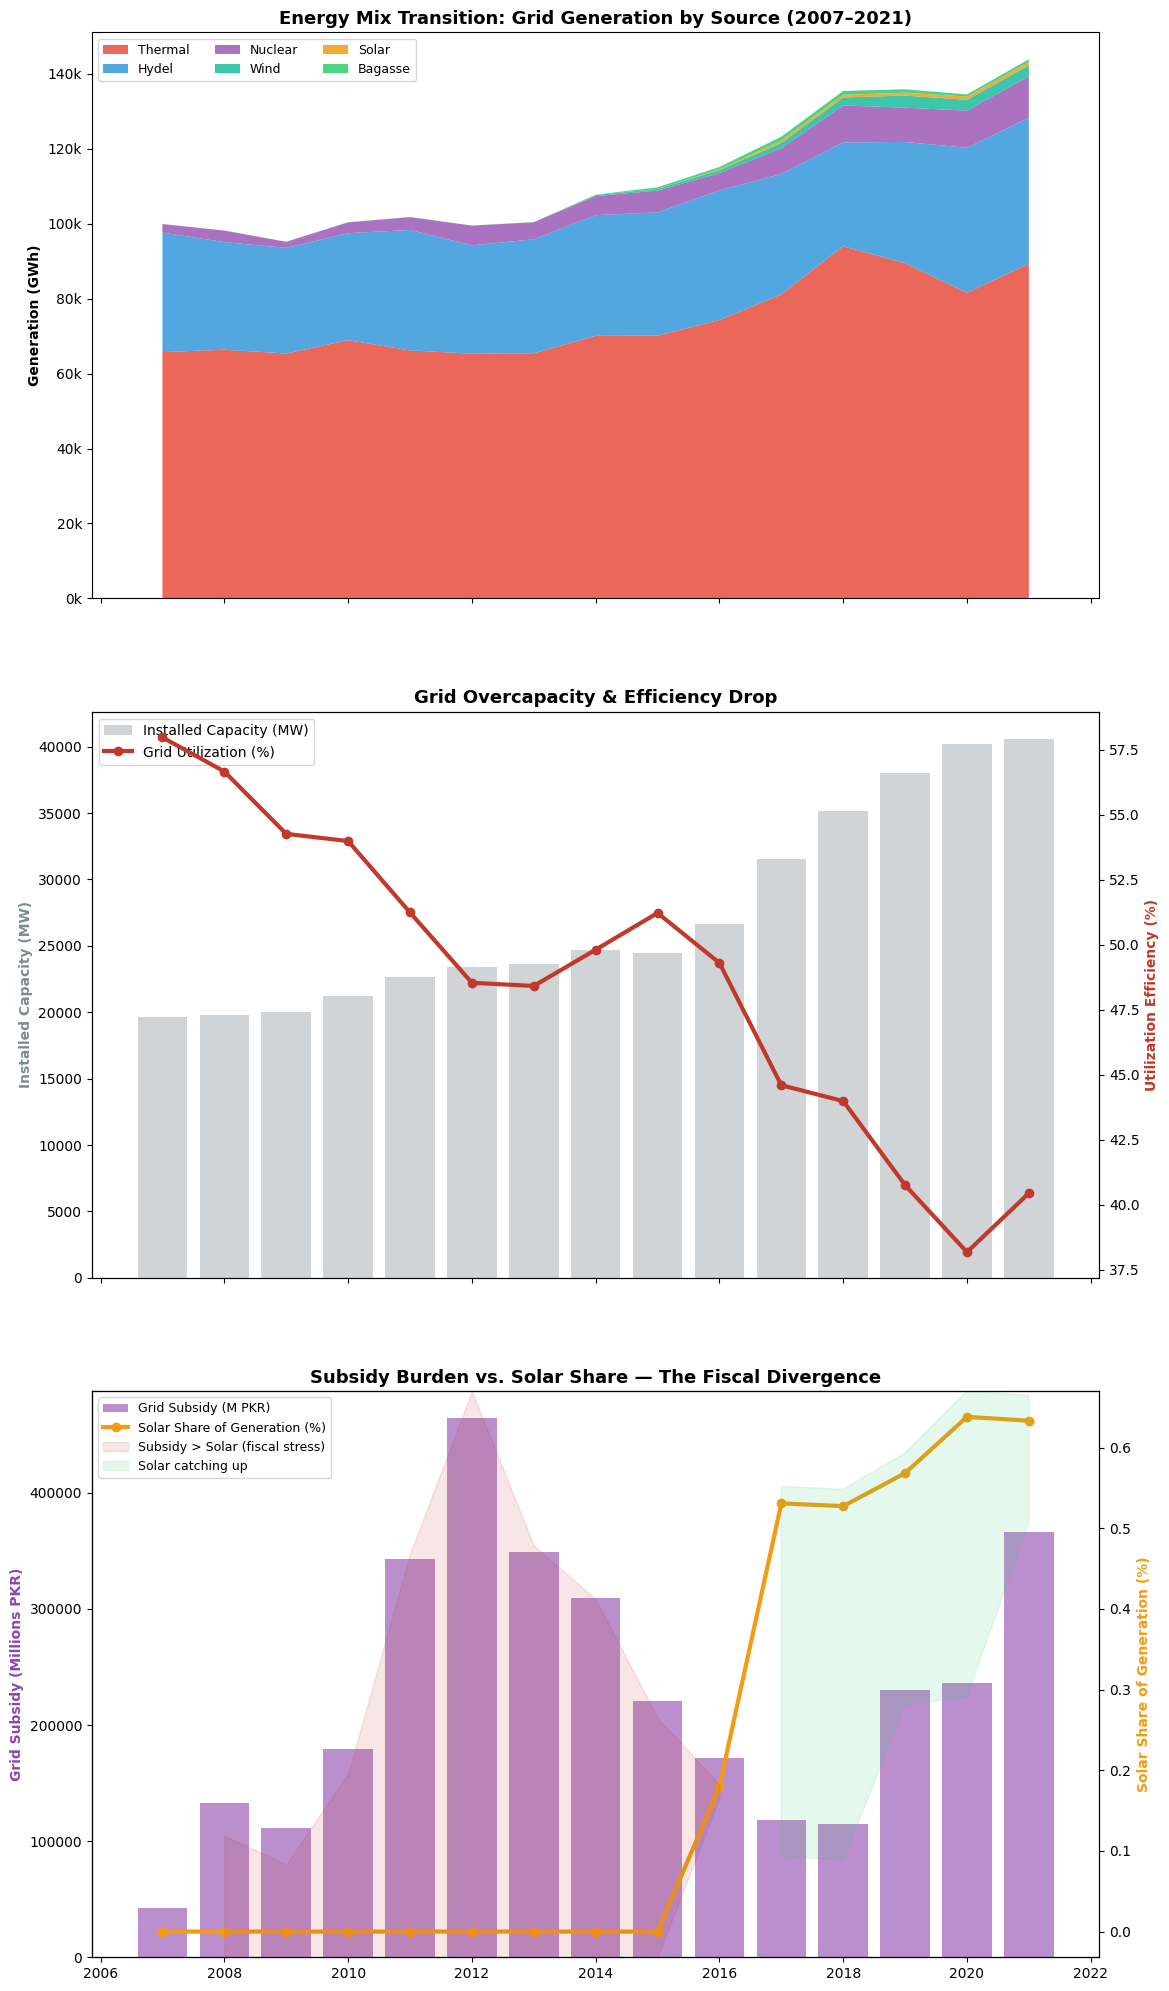

In [79]:
fig, axes = plt.subplots(3, 1, figsize=(13, 25), sharex=True)

# -- Panel 1: Stacked Area — Energy Mix Transition ----------------------------
gen_mix_cols = ['Thermal_Gen_GWh', 'Hydel_Gen_GWh', 'Nuclear_Gen_GWh',
                'Wind_Gen_GWh', 'Solar_Gen_GWh', 'Bagasse_Gen_GWh']
gen_labels   = ['Thermal', 'Hydel', 'Nuclear', 'Wind', 'Solar', 'Bagasse']
gen_colors   = ['#e74c3c', '#3498db', '#9b59b6', '#1abc9c', '#f39c12', '#2ecc71']
axes[0].stackplot(pbs_df['Fiscal_Year'],
                  [pbs_df[c] for c in gen_mix_cols],
                  labels=gen_labels, colors=gen_colors, alpha=0.85)
axes[0].set_ylabel('Generation (GWh)', fontweight='bold')
axes[0].set_title('Energy Mix Transition: Grid Generation by Source (2007–2021)',
                  fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', ncol=3, fontsize=9)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}k'))

# -- Panel 2: Installed Capacity vs Utilization Efficiency --------------------
ax2b = axes[1].twinx()
axes[1].bar(pbs_df['Fiscal_Year'], pbs_df['Total_Cap_MW'],
            color='#bdc3c7', alpha=0.7, label='Installed Capacity (MW)')
ax2b.plot(pbs_df['Fiscal_Year'], pbs_df['Total_Utilization_Pct'],
          color='#c0392b', linewidth=3, marker='o', label='Grid Utilization (%)')
axes[1].set_ylabel('Installed Capacity (MW)', color='#7f8c8d', fontweight='bold')
ax2b.set_ylabel('Utilization Efficiency (%)', color='#c0392b', fontweight='bold')
axes[1].set_title('Grid Overcapacity & Efficiency Drop', fontsize=13, fontweight='bold')
h1, l1 = axes[1].get_legend_handles_labels()
h2, l2 = ax2b.get_legend_handles_labels()
axes[1].legend(h1 + h2, l1 + l2, loc='upper left')

# # -- Panel 3: Solar Absolute Growth & Grid Share ------------------------------
# ax3b = axes[2].twinx()
# axes[2].bar(pbs_df['Fiscal_Year'], pbs_df['Solar_Gen_GWh'],
#             color='#f39c12', alpha=0.8, label='Solar Generation (GWh)')
# ax3b.plot(pbs_df['Fiscal_Year'], pbs_df['Solar_Gen_Share_Pct'],
#           color='#e67e22', linewidth=2.5, marker='s', label='Solar Share of Total (%)')
# axes[2].set_ylabel('Solar Generation (GWh)', color='#f39c12', fontweight='bold')
# ax3b.set_ylabel('Solar % of Total Generation', color='#e67e22', fontweight='bold')
# axes[2].set_title('Solar Energy: Absolute Growth and Grid Share', fontsize=13, fontweight='bold')
# h3, l3 = axes[2].get_legend_handles_labels()
# h4, l4 = ax3b.get_legend_handles_labels()
# axes[2].legend(h3 + h4, l3 + l4, loc='upper left')

# -- Panel 4: Subsidy Burden vs Solar Share (divergence chart) ----------------
# Drop rows missing either value so both series share identical x-points
pbs_gva = pbs_df.dropna(subset=['Subsidy_Millions', 'Solar_Gen_Share_Pct'])

ax4b = axes[2].twinx()

# Left axis: Subsidy (the "bad" metric rising under grid stress)
axes[2].bar(pbs_gva['Fiscal_Year'], pbs_gva['Subsidy_Millions'],
            color='#8e44ad', alpha=0.6, label='Grid Subsidy (M PKR)')
axes[2].set_ylabel('Grid Subsidy (Millions PKR)', color='#8e44ad', fontweight='bold')

# Right axis: Solar share (the "good" metric rising as solar displaces grid load)
ax4b.plot(pbs_gva['Fiscal_Year'], pbs_gva['Solar_Gen_Share_Pct'],
          color='#f39c12', linewidth=3, marker='o', label='Solar Share of Generation (%)')
ax4b.set_ylabel('Solar Share of Generation (%)', color='#f39c12', fontweight='bold')

axes[2].set_title('Subsidy Burden vs. Solar Share — The Fiscal Divergence',
                  fontsize=13, fontweight='bold')

# Shade the divergence region to make it pop visually
# Normalise both series to 0–1 so they occupy the same space for shading
sub_norm = (pbs_gva['Subsidy_Millions'] - pbs_gva['Subsidy_Millions'].min()) / \
           (pbs_gva['Subsidy_Millions'].max() - pbs_gva['Subsidy_Millions'].min())
sol_norm = (pbs_gva['Solar_Gen_Share_Pct'] - pbs_gva['Solar_Gen_Share_Pct'].min()) / \
           (pbs_gva['Solar_Gen_Share_Pct'].max() - pbs_gva['Solar_Gen_Share_Pct'].min())

ax4_norm = axes[2].twinx()
ax4_norm.set_yticks([])                          # invisible — only used for shading
ax4_norm.fill_between(pbs_gva['Fiscal_Year'], sub_norm, sol_norm,
                      where=(sub_norm > sol_norm),
                      alpha=0.12, color='#c0392b', label='Subsidy > Solar (fiscal stress)')
ax4_norm.fill_between(pbs_gva['Fiscal_Year'], sub_norm, sol_norm,
                      where=(sub_norm <= sol_norm),
                      alpha=0.12, color='#2ecc71', label='Solar catching up')
ax4_norm.set_ylim(0, 1)
ax4_norm.spines['right'].set_visible(False)

h5, l5 = axes[2].get_legend_handles_labels()
h6, l6 = ax4b.get_legend_handles_labels()
h7, l7 = ax4_norm.get_legend_handles_labels()
axes[2].legend(h5 + h6 + h7, l5 + l6 + l7, loc='upper left', fontsize=9)


#### Normalized Stock Trends

In [37]:
stocks_df = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_stocks.csv"))
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [38]:
pivot_df = stocks_df.pivot_table(index='Date', columns='Ticker', values='Close').dropna(axis=1, how='all').ffill()
normalized_stocks = (pivot_df / pivot_df.iloc[0]) * 100
target_tickers = [t for t in ['HUBC.KA', 'PAEL.KA', 'ENGRO.KA', 'PSO.KA'] if t in normalized_stocks.columns]

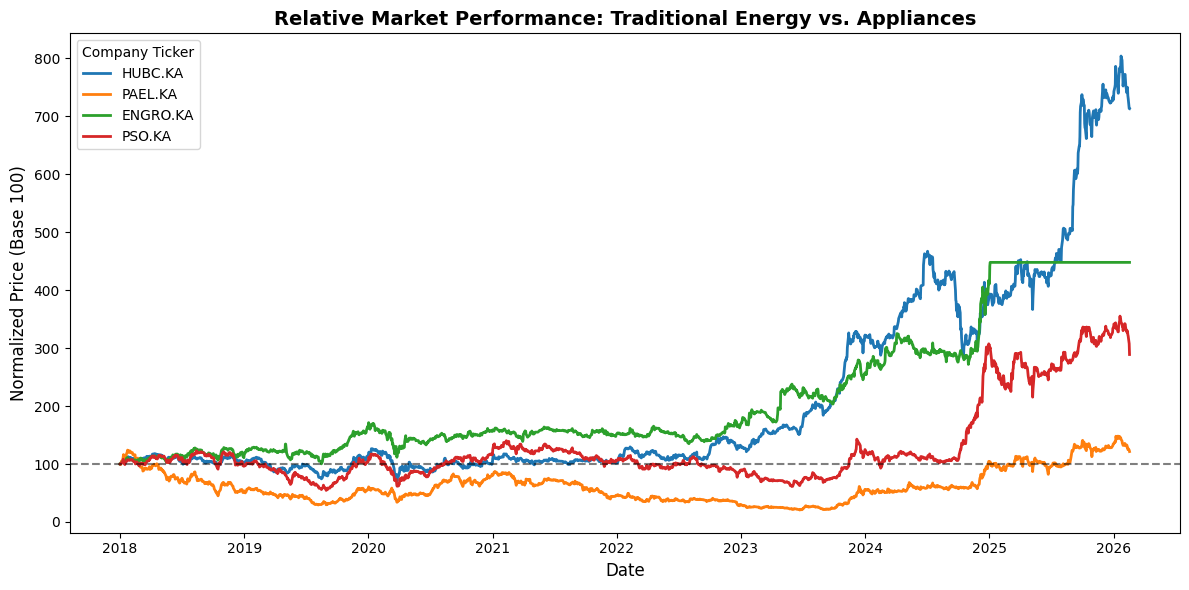

In [39]:
plt.figure(figsize=(12, 6))
for ticker in target_tickers:
    sns.lineplot(data=normalized_stocks, x=normalized_stocks.index, y=ticker, label=ticker, linewidth=2)
    
plt.axhline(100, color='black', linestyle='--', alpha=0.5)
plt.title('Relative Market Performance: Traditional Energy vs. Appliances', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price (Base 100)', fontsize=12)
plt.legend(title="Company Ticker")
plt.tight_layout()
plt.show()

#### GEOGRAPHIC SOLAR VIABILITY (Meteorological Limits)

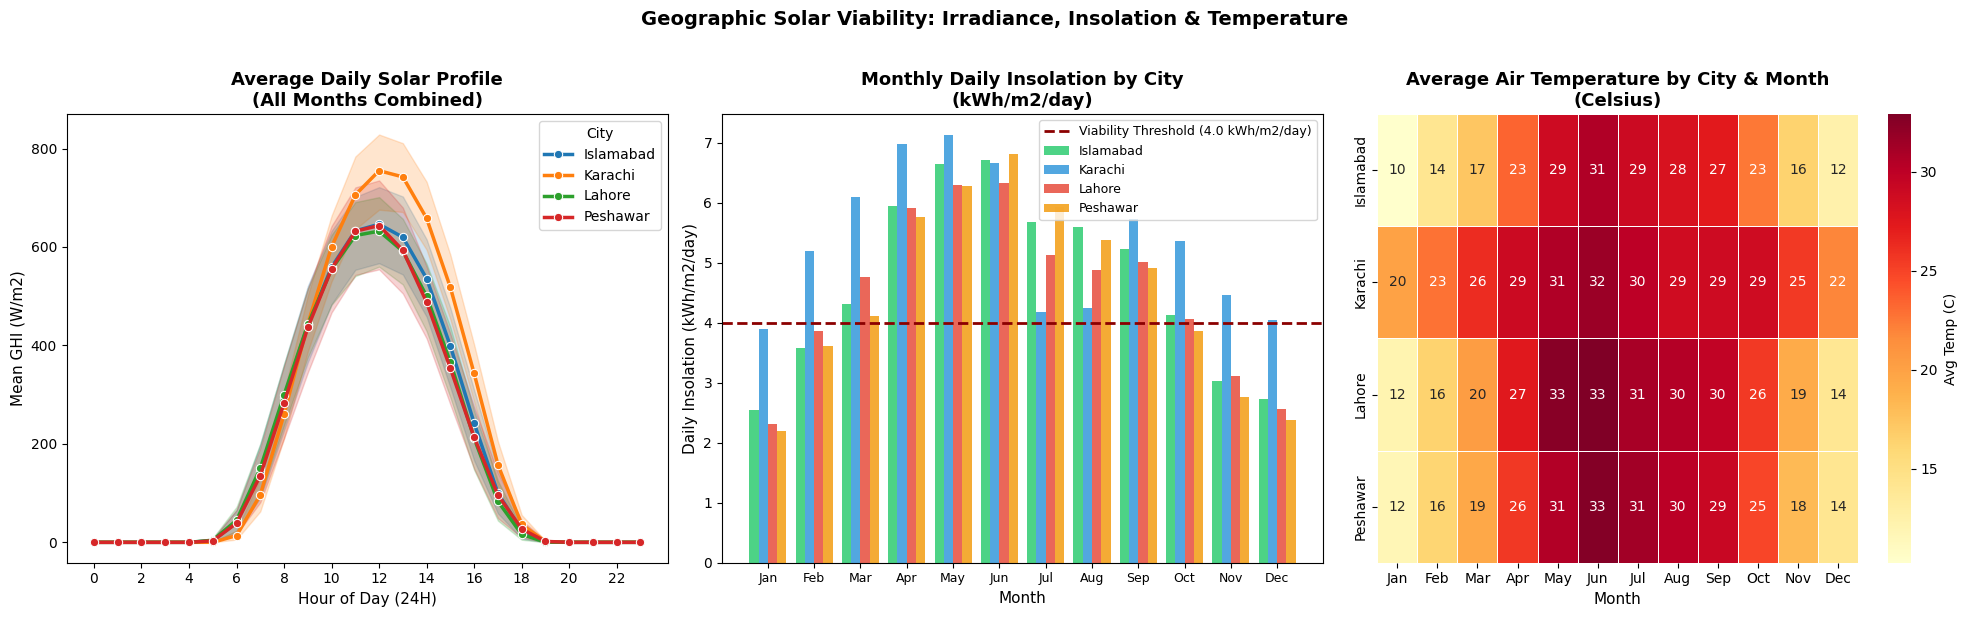


-- Months Exceeding 4.0 kWh/m2/day Viability Threshold --
  Islamabad   : Mar, Apr, May, Jun, Jul, Aug, Sep, Oct (8/12 months)
  Karachi     : Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec (11/12 months)
  Lahore      : Mar, Apr, May, Jun, Jul, Aug, Sep, Oct (8/12 months)
  Peshawar    : Mar, Apr, May, Jun, Jul, Aug, Sep (7/12 months)


In [40]:
solar_rad_df = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_solar_radiation_by_city.csv"))
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# -- Panel 1: Average Diurnal Profile ------------------------------------------
sns.lineplot(data=solar_rad_df, x='Hour', y='GHI', hue='City', ax=axes[0], linewidth=2.5, marker='o')
axes[0].set_title('Average Daily Solar Profile\n(All Months Combined)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Hour of Day (24H)', fontsize=11)
axes[0].set_ylabel('Mean GHI (W/m2)', fontsize=11)
axes[0].set_xticks(range(0, 24, 2))

# -- Panel 2: Monthly Insolation Bar Chart + 4.0 kWh Threshold ----------------
# Daily Insolation (kWh/m2/day) = sum(hourly_mean_GHI) * 1h / 1000
insolation_df = solar_rad_df.groupby(['City','Month'])['GHI'].sum().reset_index()
insolation_df['Daily_Insolation_kWh'] = insolation_df['GHI'] / 1000

month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
city_colors  = {'Lahore':'#e74c3c','Karachi':'#3498db','Islamabad':'#2ecc71','Peshawar':'#f39c12'}
x = np.arange(1, 13)
width = 0.2
for k, (city, grp) in enumerate(insolation_df.groupby('City')):
    grp_sorted = grp.sort_values('Month')
    axes[1].bar(x + k*width, grp_sorted['Daily_Insolation_kWh'],
                width, label=city, color=city_colors.get(city,'grey'), alpha=0.85)

# KEY FIX: Draw viability threshold that the report claims
axes[1].axhline(y=4.0, color='darkred', linestyle='--', linewidth=2,
                label='Viability Threshold (4.0 kWh/m2/day)')
axes[1].set_xticks(x + width*1.5)
axes[1].set_xticklabels(month_labels, fontsize=9)
axes[1].set_title('Monthly Daily Insolation by City\n(kWh/m2/day)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Daily Insolation (kWh/m2/day)', fontsize=11)
axes[1].legend(fontsize=9)

# -- Panel 3: Temperature Heatmap (previously loaded but unused column) --------
avg_temp = solar_rad_df.groupby(['City','Month'])['Temperature'].mean().reset_index()
temp_pivot = avg_temp.pivot(index='City', columns='Month', values='Temperature')
temp_pivot.columns = month_labels
sns.heatmap(temp_pivot, ax=axes[2], cmap='YlOrRd', annot=True, fmt='.0f',
            linewidths=0.5, cbar_kws={'label':'Avg Temp (C)'})
axes[2].set_title('Average Air Temperature by City & Month\n(Celsius)',
                  fontsize=13, fontweight='bold')
axes[2].set_xlabel('Month', fontsize=11)
axes[2].set_ylabel('')

plt.suptitle('Geographic Solar Viability: Irradiance, Insolation & Temperature',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n-- Months Exceeding 4.0 kWh/m2/day Viability Threshold --")
viable = insolation_df[insolation_df['Daily_Insolation_kWh'] >= 4.0]
for city, grp in viable.groupby('City'):
    months = [month_labels[m-1] for m in sorted(grp['Month'])]
    print(f"  {city:12s}: {', '.join(months)} ({len(months)}/12 months)")

#### REAL-WORLD SOLAR OUTPUT (Kaggle Generation Trend)

In [41]:
solar_gen_df = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_solar_generation.csv"))
solar_gen_df['Date'] = pd.to_datetime(solar_gen_df['Date'])
solar_gen_df.set_index('Date', inplace=True)

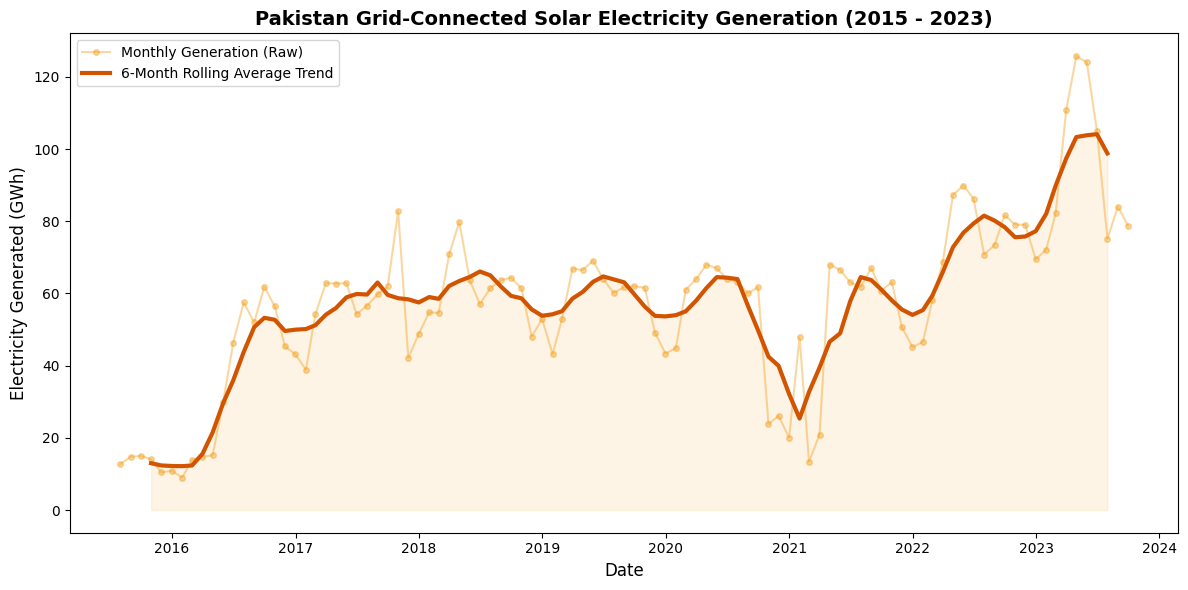

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(solar_gen_df.index, solar_gen_df['Solar_Gen_GWh'], color='#f39c12', alpha=0.4, marker='o', markersize=4, label='Monthly Generation (Raw)')

rolling_avg = solar_gen_df['Solar_Gen_GWh'].rolling(window=6, center=True).mean()
plt.plot(solar_gen_df.index, rolling_avg, color='#d35400', linewidth=3, label='6-Month Rolling Average Trend')
plt.fill_between(solar_gen_df.index, rolling_avg, color='#f39c12', alpha=0.1)

plt.title('Pakistan Grid-Connected Solar Electricity Generation (2015 - 2023)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Generated (GWh)', fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Correlation Analysis: Solar Growth vs. Grid Utilization Efficiency

Direct test of the core thesis: as solar generation increases, does grid utilization efficiency decline? A negative correlation supports the Utility Death Spiral narrative.

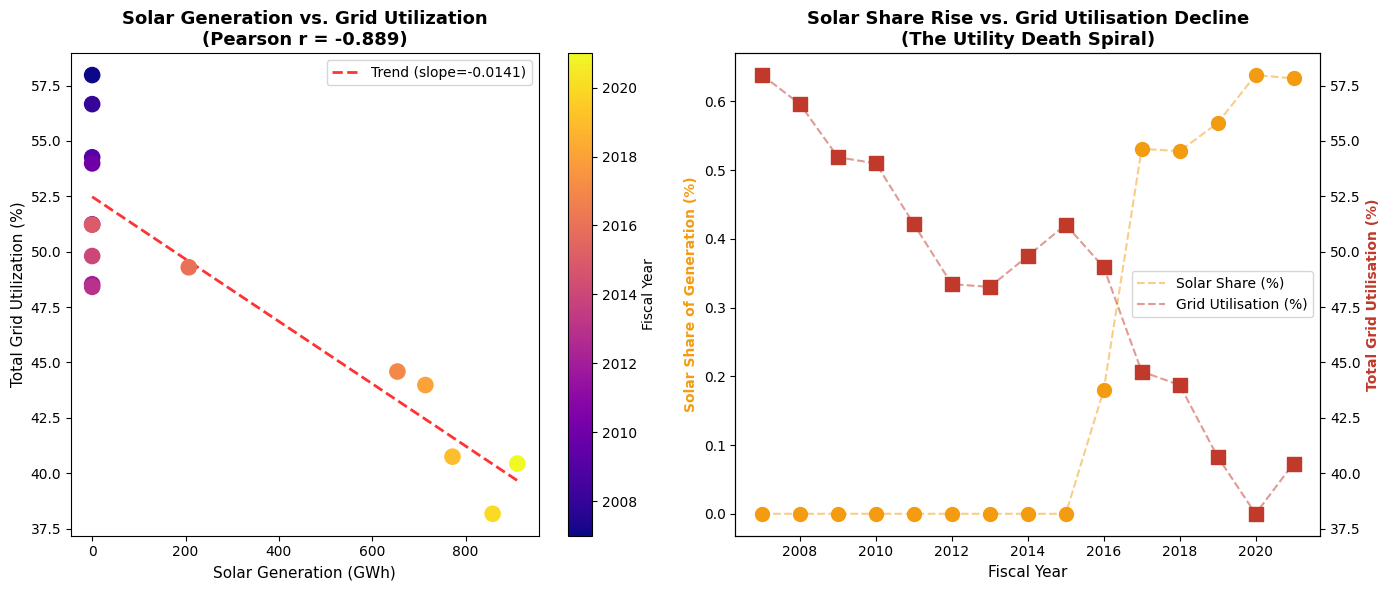

-- Correlation Summary --
  Solar Gen GWh       vs Grid Utilization: r = -0.889
  Solar Gen Share (%) vs Grid Utilization: r = -0.886
  Strong negative correlation: confirms the Utility Death Spiral thesis.


In [43]:
pbs_corr = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_pbs.csv"))
pbs_corr['Solar_Gen_Share_Pct'] = (pbs_corr['Solar_Gen_GWh'] / pbs_corr['Total_Gen_GWh']) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -- Scatter 1: Solar GWh vs Grid Utilization % --------------------------------
sc = axes[0].scatter(pbs_corr['Solar_Gen_GWh'], pbs_corr['Total_Utilization_Pct'],
                     c=pbs_corr['Fiscal_Year'], cmap='plasma', s=120, zorder=5)
plt.colorbar(sc, ax=axes[0], label='Fiscal Year')
mask = pbs_corr[['Solar_Gen_GWh','Total_Utilization_Pct']].notna().all(axis=1)
z = np.polyfit(pbs_corr.loc[mask,'Solar_Gen_GWh'], pbs_corr.loc[mask,'Total_Utilization_Pct'], 1)
xs = np.linspace(pbs_corr['Solar_Gen_GWh'].min(), pbs_corr['Solar_Gen_GWh'].max(), 100)
axes[0].plot(xs, np.poly1d(z)(xs), 'r--', linewidth=2, alpha=0.8, label=f'Trend (slope={z[0]:.4f})')
corr1 = pbs_corr['Solar_Gen_GWh'].corr(pbs_corr['Total_Utilization_Pct'])
axes[0].set_title(f'Solar Generation vs. Grid Utilization\n(Pearson r = {corr1:.3f})',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Solar Generation (GWh)', fontsize=11)
axes[0].set_ylabel('Total Grid Utilization (%)', fontsize=11)
axes[0].legend()

# -- Scatter 2: Solar Share % vs Utilization over time -------------------------
ax2r = axes[1].twinx()
axes[1].scatter(pbs_corr['Fiscal_Year'], pbs_corr['Solar_Gen_Share_Pct'], color='#f39c12', s=100, zorder=5)
axes[1].plot(pbs_corr['Fiscal_Year'], pbs_corr['Solar_Gen_Share_Pct'], color='#f39c12', alpha=0.5, linestyle='--', label='Solar Share (%)')
ax2r.scatter(pbs_corr['Fiscal_Year'], pbs_corr['Total_Utilization_Pct'], color='#c0392b', s=100, marker='s', zorder=5)
ax2r.plot(pbs_corr['Fiscal_Year'], pbs_corr['Total_Utilization_Pct'], color='#c0392b', alpha=0.5, linestyle='--', label='Grid Utilisation (%)')
axes[1].set_ylabel('Solar Share of Generation (%)', color='#f39c12', fontweight='bold')
ax2r.set_ylabel('Total Grid Utilisation (%)', color='#c0392b', fontweight='bold')
axes[1].set_title('Solar Share Rise vs. Grid Utilisation Decline\n(The Utility Death Spiral)',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Fiscal Year', fontsize=11)
h1,l1 = axes[1].get_legend_handles_labels()
h2,l2 = ax2r.get_legend_handles_labels()
axes[1].legend(h1+h2, l1+l2, loc='center right')

plt.tight_layout()
plt.show()

corr2 = pbs_corr['Solar_Gen_Share_Pct'].corr(pbs_corr['Total_Utilization_Pct'])
print("-- Correlation Summary --")
print(f"  Solar Gen GWh       vs Grid Utilization: r = {corr1:.3f}")
print(f"  Solar Gen Share (%) vs Grid Utilization: r = {corr2:.3f}")
if corr1 < -0.5:
    print("  Strong negative correlation: confirms the Utility Death Spiral thesis.")
elif corr1 < 0:
    print("  Negative correlation: partial support for thesis.")
else:
    print("  Weak/positive: further investigation warranted.")

#### PUBLIC SENTIMENT (YouTube Discourse)

In [44]:
yt_df = pd.read_csv(os.path.join(Config.CLEANED_DATA_DIR, "cleaned_youtube.csv"))
yt_df['Published_At'] = pd.to_datetime(yt_df['Published_At']).dt.tz_localize(None)

In [45]:
monthly_comments = yt_df.set_index('Published_At').resample('ME').size().reset_index(name='Comment Volume')
monthly_comments = monthly_comments[monthly_comments['Comment Volume'] > 0]

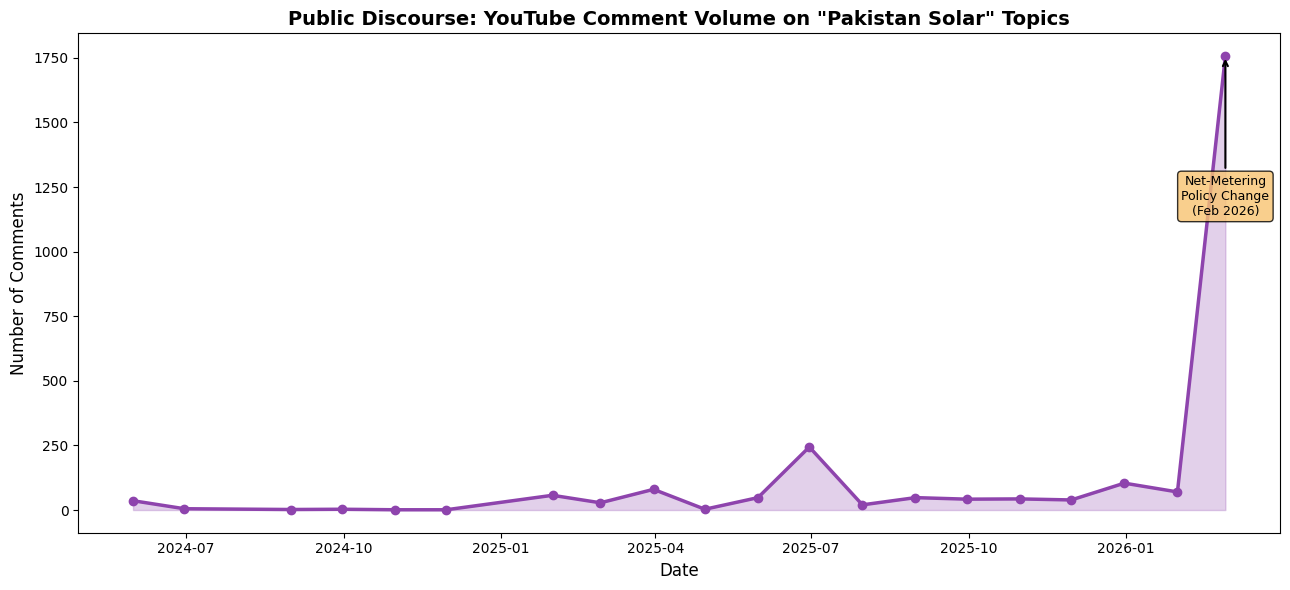

In [46]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.fill_between(monthly_comments['Published_At'], monthly_comments['Comment Volume'],
                color='#8e44ad', alpha=0.25)
ax.plot(monthly_comments['Published_At'], monthly_comments['Comment Volume'],
        color='#8e44ad', linewidth=2.5, marker='o', markersize=6)

# Annotate the key policy event driving the spike
peak_idx = monthly_comments['Comment Volume'].idxmax()
peak_row  = monthly_comments.loc[peak_idx]
ax.annotate('Net-Metering\nPolicy Change\n(Feb 2026)',
            xy=(peak_row['Published_At'], peak_row['Comment Volume']),
            xytext=(peak_row['Published_At'], peak_row['Comment Volume'] * 0.65),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            fontsize=9, ha='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#f8c471', alpha=0.8))

ax.set_title('Public Discourse: YouTube Comment Volume on "Pakistan Solar" Topics',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
plt.tight_layout()
plt.show()